Tutorial based on the following Spektral example<br />
https://github.com/danielegrattarola/spektral/blob/master/examples/classification_delaunay.py

Data set source : "JPlogP: an improved logP predictor trained using predicted data"<br />
https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0316-5

Conda environment<br />
File conda-env_spektral.txt

In [1]:
# Imports
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from spektral.layers import GraphAttention, GlobalAttentionPool
from spektral.utils import label_to_one_hot, load_sdf, nx_to_numpy
from spektral.chem import sdf_to_nx

Using TensorFlow backend.
/home/lionel/anaconda3/envs/spektral/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lionel/anaconda3/envs/spektral/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lionel/anaconda3/envs/spektral/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lionel/a

In [2]:
# Molecules loading in the SDF internal format of Spektral (not true SD but JSON like)
# (5k molecules from the Delaunay et al. article, filtered to contain only CHNO atoms)
sdf_loaded = load_sdf("data/Trainingset_Delaunay-CHNO5000selected.sdf", amount=None)

Reading SDF


In [3]:
# Conversion from SDF to nx.Graphs with Spektral
sdf_nx = sdf_to_nx(sdf_loaded, keep_hydrogen=True)
print(len(sdf_nx))

5000


In [4]:
# Extraction from nx.Graphs of the adjency matrices and the nodes attributes of the molecules
sdf_adj, sdf_node, _ = nx_to_numpy(sdf_nx,
                                   nf_keys=['atomic_num'],
                                   ef_keys=['type']
                                  )

In [5]:
# Node attributes preprocessing
uniq_node = np.unique([v for x in sdf_node for v in np.unique(x)])
node = [label_to_one_hot(x, uniq_node) for x in sdf_node]

In [6]:
# Labels import and preprocessing
label_pd = pd.read_csv("data/Trainingset_Delaunay-CHNO5000selected_label.csv")
label = label_pd.to_numpy()

print(label.shape)

(5000, 2)


In [7]:
# Model parameters
N = node[0].shape[-2]          # Number of nodes in the graphs
F = node[0].shape[-1]          # Original feature dimensionality
n_classes = label.shape[-1]    # Number of classes

l2_reg = 5e-4                  # Regularization rate for l2
learning_rate = 1e-4           # Learning rate for Adam
epochs = 50                     # Number of training epochs
batch_size = 32                # Batch size
es_patience = 5                # Patience for early stopping
es_delta = 0.001                # Min Delta for early stopping

print('Number of nodes in the graphs : ',N)
print('Features dimenssionality :',F)
print('Number of classes :',n_classes)

Number of nodes in the graphs :  58
Features dimenssionality : 4
Number of classes : 2


In [8]:
# Train/test split : 10%
A_train, A_test, \
X_train, X_test, \
y_train, y_test = train_test_split(sdf_adj, node, label, test_size=0.1)

In [9]:
# Model definition
X_in = Input(shape=(N, F))
A_in = Input((N, N))

gc1 = GraphAttention(32, activation='relu', kernel_regularizer=l2(l2_reg))([X_in, A_in])
gc2 = GraphAttention(64, activation='relu', kernel_regularizer=l2(l2_reg))([gc1, A_in])
pool = GlobalAttentionPool(128)(gc2)

output = Dense(n_classes, activation='softmax')(pool)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
# Build model
model = Model(inputs=[X_in, A_in], outputs=output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 58, 4)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 58, 58)       0                                            
__________________________________________________________________________________________________
graph_attention_1 (GraphAttenti (None, 58, 32)       224         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
graph_attention_2 (GraphAttenti (None, 58, 64)       2240        graph_attention_1[0][0]  

In [11]:
# Train model : 10% validation split
history = model.fit([X_train, A_train],
              y_train,
              batch_size=batch_size,
              validation_split=0.1,
              epochs=epochs,
              callbacks=[
                  EarlyStopping(monitor='val_loss', min_delta=es_delta, patience=es_patience, verbose=1, restore_best_weights=True)
              ])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4050 samples, validate on 450 samples
Epoch 1/50
4050/4050 [==============================] - 44s 11ms/step - loss: 0.4901 - acc: 0.7859 - val_loss: 0.3404 - val_acc: 0.8667
Epoch 2/50
4050/4050 [==============================] - 43s 11ms/step - loss: 0.3677 - acc: 0.8462 - val_loss: 0.3110 - val_acc: 0.8822
Epoch 3/50
4050/4050 [==============================] - 45s 11ms/step - loss: 0.3568 - acc: 0.8496 - val_loss: 0.3125 - val_acc: 0.8844
Epoch 4/50
4050/4050 [==============================] - 42s 10ms/step - loss: 0.3450 - acc: 0.8560 - val_loss: 0.2925 - val_acc: 0.8956
Epoch 5/50
4050/4050 [==============================] - 44s 11ms/step - loss: 0.3387 - acc: 0.8573 - val_loss: 0.3062 - val_acc: 0.8822
Epoch 6/50
4050/4050 [==============================] - 46s 11ms/step - loss: 0.3341 - acc: 0.8580 - val_loss: 0.2811 - val_acc: 0.9022
Epoch 7/50
4050/4050 [=====================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


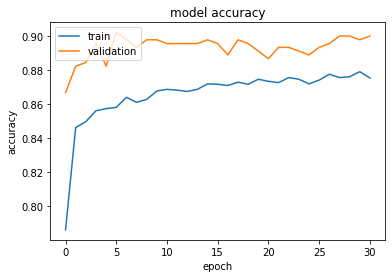

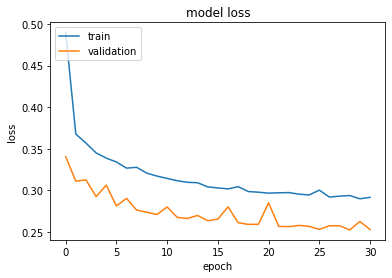

In [16]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([X_test, A_test],
                              y_test,
                              batch_size=batch_size)
print('Done.\n'
      'Test loss: {}\n'
      'Test accuracy: {}'.format(*eval_results))

Evaluating model.
500/500 [==============================] - 2s 3ms/step
Done.
Test loss: 0.28709950852394106
Test accuracy: 0.8699999990463256


In [14]:
# Predictions calculation
y_test_pred = model.predict([X_test, A_test])


y_test_classes = y_test.argmax(axis=-1)
y_pred_classes = y_test_pred.argmax(axis=-1)


In [15]:
# Matrix confusion
y_test_classes = y_test.argmax(axis=-1)
y_pred_classes = y_test_pred.argmax(axis=-1)
confusion_matrix(y_test_classes, y_pred_classes)

array([[306,  19],
       [ 46, 129]])